# Detection and Recognition of Ancient Greek Characters on Papyrus

In this tutorial we will develop a simple pipeline for the **detection** and **recognition** of characters written in Ancient Greek on papyrus manuscripts.  
We will use **YOLOv8** (Ultralytics) for object detection, and we will also explore utilities to **visualize** and **export** the predictions in different formats.

---

## Why YOLOv8?

We choose [YOLOv8 (Ultralytics)](https://github.com/ultralytics/ultralytics) because:
- It directly supports training from COCO JSON annotation files.
- It provides simple and clean PyTorch APIs.
- It has excellent documentation and active support.

---

## 📂 Workspace Overview

Our workspace will contain the following components:

### `data/`
Download the dataset from [Zenodo](https://zenodo.org/records/13825619).  
Once downloaded, extract the archive inside the `data` folder.

The archive contains:
- Training data
- Test data
- An `answer` folder with ground-truth annotations for the test set
- Additional material

The dataset is in **COCO format** for object detection:  
- Images of papyri (fragments of the *Iliad*)  
- A JSON file with bounding box annotations for every Ancient Greek character (24 classes).



### `src/`
The `src` folder contains utility code for this tutorial:
- `coco/`: functions to compute evaluation metrics following the COCO standard  
- `datasets/`: functions to manipulate and prepare datasets for YOLO  
- `utils/`: additional utilities for visualization and format conversion  


# 🏘️Create Environment
Run this command to prepare your environment:

In [ ]:
!conda env create -f environment.yml

Now be careful to select your environment in the notebook

## 🛠️ Data Preparation

Download the dataset from [Zenodo](https://zenodo.org/records/13825619)  and extract yhe achive into the `data/` directory:


The dataset is not originally split into **training** and **validation** subsets.  
We will create our own split so that the structure looks like this:

```
dataset/
 ├── train/
 │    ├── images/
 │    └── annotations.json
 ├── val/
 │    ├── images/
 │    └── annotations.json
```

To do this, we can use the utilities found in `datasets.yolo_dataset`. Specifically, we can use the `create_YOLO_train_val()` method.

In [8]:
from src.datasets.yolo_dataset import create_YOLO_train_val

create_YOLO_train_val(in_dataset_path="data/ICDAR2023_Competition_on_Detection_and_Recognition_of_Greek_Letters_on_Papyri_Dataset/2a.Training",
                      out_dataset_path="data/YOLO_data",
                      bt_filter=["bt3"]
                      )

Prepare Annotations: 100%|██████████| 35597/35597 [00:00<00:00, 97800.66it/s] 


## 🚀 Training a YOLO Model

Now we can train a YOLO model to detect and recognize Ancient Greek characters.

We will use the Ultralytics YOLOv8 API.

**_NOTE:_**  Try different parameters for the training. In particular, consider different sizes for images: 640, 1024,

In [9]:
from ultralytics import YOLO

#  We can download a pretrained model
model = YOLO("yolov8s.pt")


# or we can load a local model:
# model = YOLO("test_network/test1/weights/last.pt")

# n = nano
# s = small
# m = medieum
# ....

# Training the model
# If you have selected a local model, you can continue the training using the parameter resume = True
model.train(
    data = "data/YOLO_data/dataset.yaml",
    epochs = 100,
    patience = 20,
    imgsz =  640, # 640 ! 1024 ! 1280
    batch = 2,
    lr0 = 1e-3,
    iou = 0.7,
    workers = 4,
    project = "checkpoints_test",
    name = "YOLO_test",
    #resume = True
)


Ultralytics 8.3.197 🚀 Python-3.11.13 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/YOLO_data/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLO_test, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d7cede55410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.

After training, YOLO will create a folder `checkpoints` containing the weights of the netwoek.

## 🔎 Testing the Model

We can now test the trained model on new images.
Let’s create a folder `data/images/` and copy some test images there.

**_NOTE:_** I suggest you choose from the images in the test set

In [12]:
model_path = "checkpoints_test/YOLO_test/weights/best.pt"


image 1/2 /home/giuseppe/tmp/icdar_tutorial/data/images/Brux_Inv_7160.jpg: 640x480 3 Θs, 15 Αs, 9 Τs, 16 Εs, 3 Κs, 2 Μs, 1 Φ, 2 Ρs, 4 Νs, 1 Λ, 2 Ηs, 1 Υ, 1 Χ, 2 Δs, 7 Οs, 8 Ιs, 6 Ϲs, 38.8ms
image 2/2 /home/giuseppe/tmp/icdar_tutorial/data/images/PSI_XIV_1376_r.jpg: 640x256 16 Αs, 13 Τs, 25 Εs, 2 Κs, 5 Ωs, 2 Μs, 5 Φs, 6 Πs, 17 Νs, 1 Λ, 4 Ηs, 18 Οs, 9 Ιs, 8 Ϲs, 41.3ms
Speed: 1.9ms preprocess, 40.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


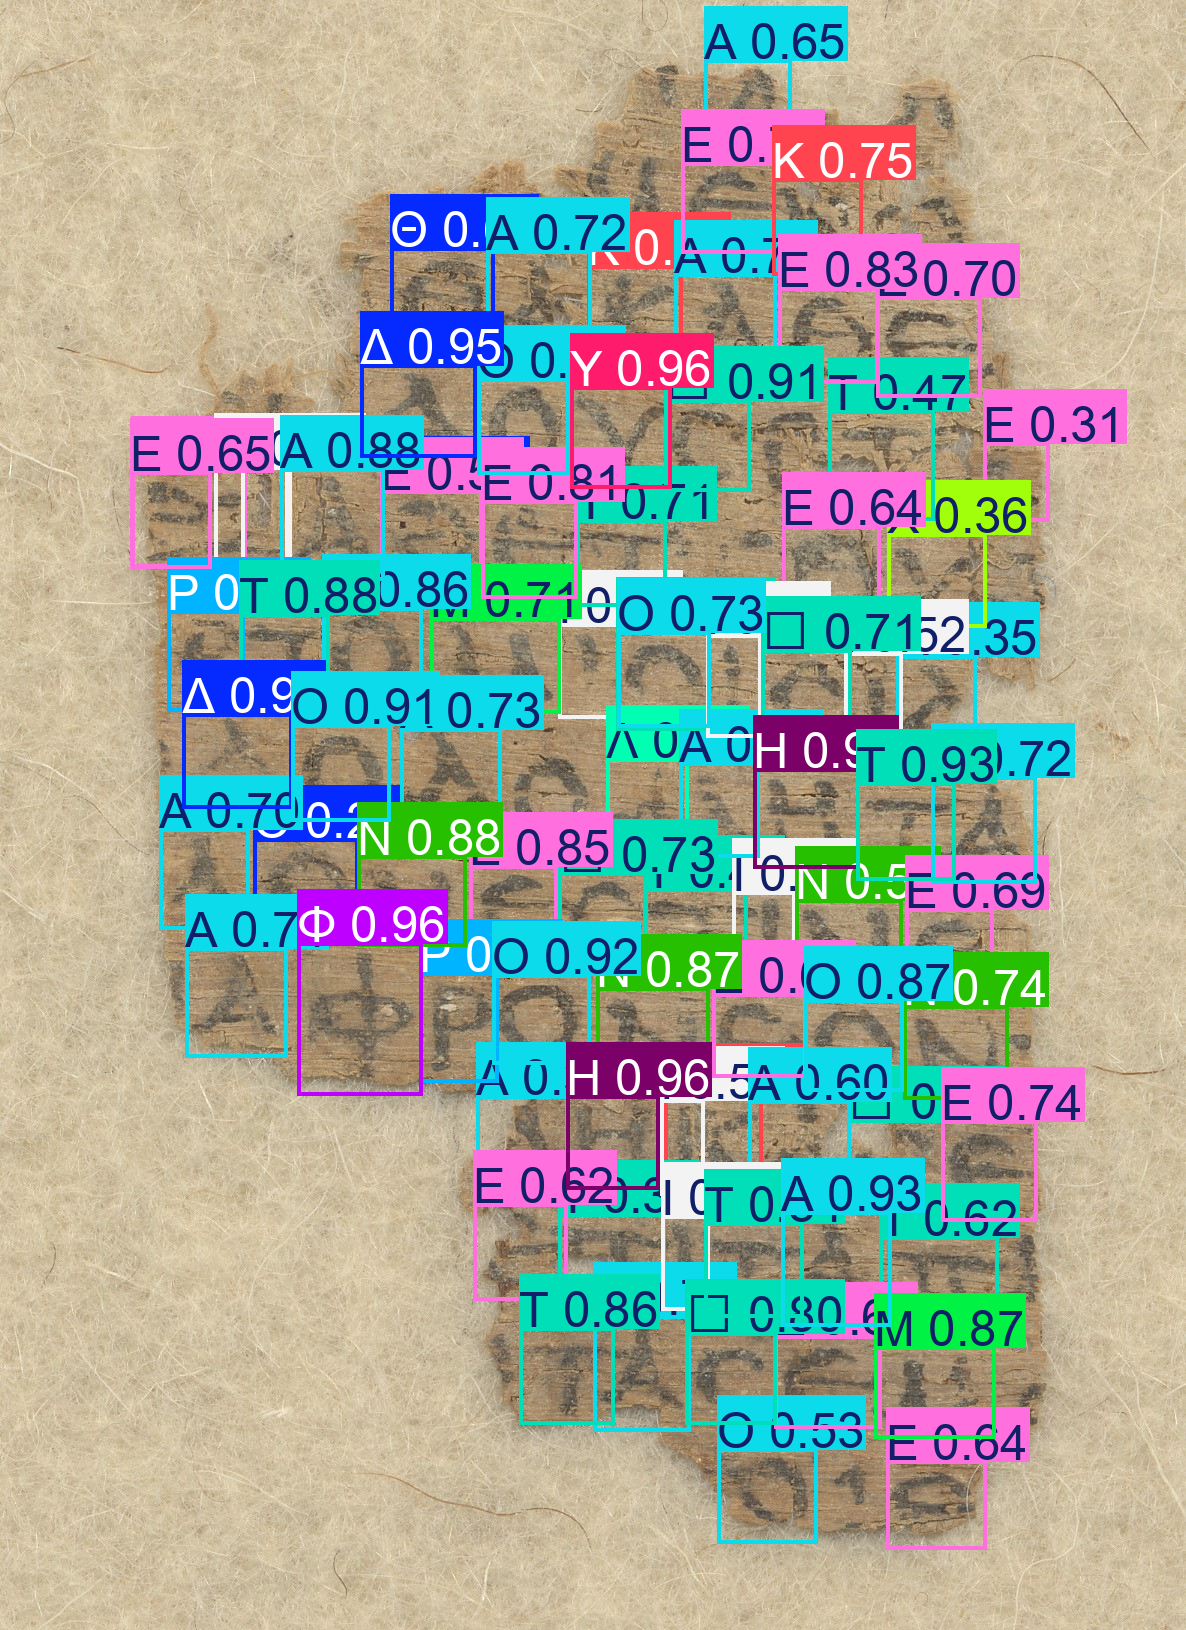

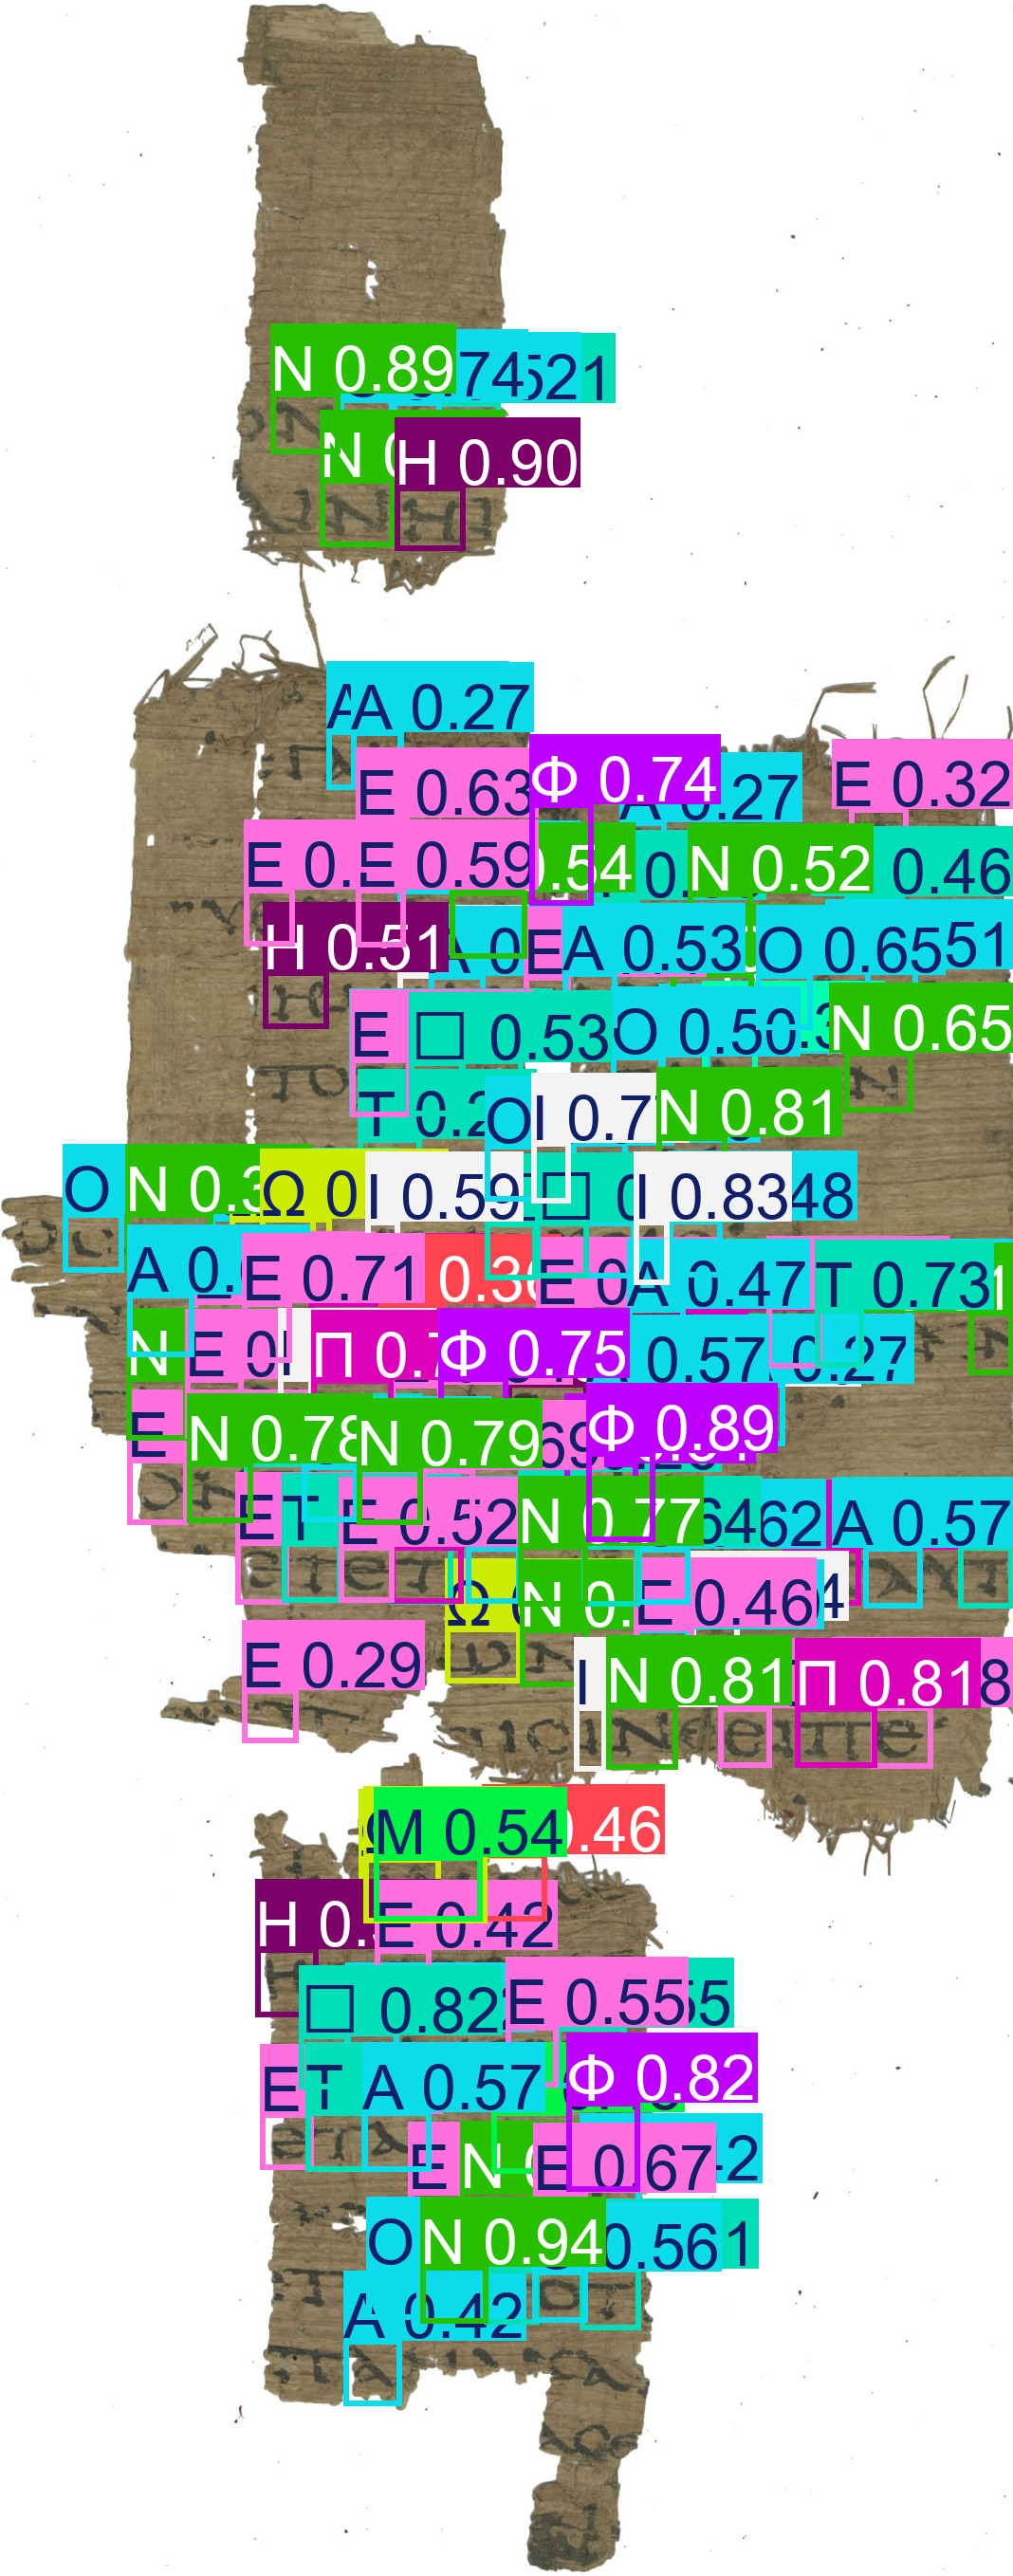

In [13]:
import os
from ultralytics import YOLO
from IPython.display import Image


image_to_test = "data/images"
out_folder = "data/out"

# Load the model to test
model = YOLO(model_path) 

# Predict
results = model(image_to_test)

# Save
for r in results:
    # Save output
    img_name = os.path.basename(r.path)
    os.makedirs(os.path.join(out_folder, os.path.splitext(img_name)[0]), exist_ok=True)

    # Salva the images with annotations
    r.save(os.path.join(out_folder, os.path.splitext(img_name)[0], "prediction.png"))

    display(Image(filename=os.path.join(out_folder, os.path.splitext(img_name)[0], "prediction.png")))

The annotated images are saved in `data/out/`.

They give us a quick impression of the model’s performance, but are not always easy to edit or use further.

### 📑 Exporting Predictions

For better usability, we want to export predictions in standard formats.

1. COCO JSON

We first export the detections into the COCO JSON format, which is supported by many third-party tools.

In [ ]:
from ultralytics import YOLO
from src.datasets.yolo_dataset import converto_out_COCO
import json
import os 

image_to_test = "data/images"
out_folder = "data/out"

os.makedirs(out_folder, exist_ok=True)

# Load the model to test
model = YOLO(model_path) 

# Predict
results = model(image_to_test)

# save
for r in results:
    img_name = os.path.basename(r.path)
    os.makedirs(os.path.join(out_folder, os.path.splitext(img_name)[0]), exist_ok=True)

    # save JSON
    coco_data = converto_out_COCO(r)
    with open(os.path.join(out_folder, os.path.splitext(img_name)[0], "prediction.json"), "w") as f:
        json.dump(coco_data, f, indent=4, ensure_ascii=False)

    # Save output
    r.save(os.path.join(out_folder, os.path.splitext(img_name)[0], "prediction.jpg"))

This format requires the original images to visualize annotations properly.

2. PAP Format

To simplify distribution and interaction, we can encapsulate both the image and the annotations in a single `.PAP` file.
This way, users only need to handle one file.

In [ ]:
from src.utils.target_utils import create_pap
import os
from tqdm import tqdm

out_dir = "data/out"
img_dir = "data/images"

for img_name in tqdm(os.listdir(img_dir), desc="Create PAP files"):
    img_path = os.path.join(img_dir, img_name)
    json_file = os.path.join(out_dir, os.path.splitext(img_name)[0], "prediction.json")    

    create_pap(img_path, json_file, save_img=False)


These `.PAP` files can be shared and visualized independently.

For example, using the online free tool [GlyFix](https://glyfix.scicore.unibas.ch/corrector.html?toml=pyscript.toml&project_file=new)

# Model Comparison

In this final section, we evaluate the performance of different YOLO models trained on the Iliad papyrus dataset.  
The comparison is based on the **COCO-style mean Average Precision (mAP)**, using the standard metric:

- **mAP@[.5:.95]**: Average precision across IoU thresholds from 0.5 to 0.95 (step 0.05).  

We calculate the separate performances for Character Detection only and then for the Recognition phase.


In [ ]:
from ultralytics import YOLO
import json
from src.datasets.yolo_dataset import converto_out_COCO
from src.datasets.categories import CATEGORIES_DECODING
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from src.coco.coco_eval import summarizeCustom
import os

# Load model
model = YOLO(model_path) 


testset_path = "data/ICDAR2023_Competition_on_Detection_and_Recognition_of_Greek_Letters_on_Papyri_Dataset/2b.Testing"
test_path = "data/ICDAR_test.json"

COCOeval.summarizeCustom = summarizeCustom

# create COCO gt
if not os.path.exists(os.path.join(testset_path, "test.json")):
    with open(test_path) as f:
        coco_data_gt = json.load(f)
    img_ids = []
    for img in coco_data_gt["images"]:
        img_ids.append(img["id"])
    #img_ids = [3]
    images = []
    for img in coco_data_gt["images"]:
        if img["id"] in img_ids:
            images.append(img)

    annotations = []
    for ann in coco_data_gt['annotations']:
        if ann["image_id"] in img_ids:
            annotations.append({
                "id": ann['id'],
                "image_id": ann['image_id'],
                "category_id": ann['category_id'],
                "bbox": ann['bbox'],
                "iscrowd": 0,
                "area": ann['bbox'][2] * ann['bbox'][3]
            })
    coco_data_gt['annotations'] = annotations
    coco_data_gt['images'] = images
    coco_data_gt['info'] = {"version": 0}
    with open(os.path.join(testset_path, "test.json"), "w", encoding="utf-8") as f:
        json.dump(coco_data_gt, f, indent=4, ensure_ascii=False)


coco_gt = COCO(os.path.join(testset_path, "test.json"))

# predict images
image_ids = coco_gt.getImgIds()
#image_ids = [3]
coco_results = []

ann_id = 0
for img_id in image_ids:
    img_info = coco_gt.loadImgs(img_id)[0]
    file_name = img_info["img_url"].replace("./", "").replace("homer2/", "")
    img_path = os.path.join(testset_path, file_name)

    results = model(img_path)

    coco_data = converto_out_COCO(results[0], img_id=img_id, ann_id=ann_id)
    ann_id += len(coco_data['annotations'])

    for ann in coco_data['annotations']:
        ann['category_id'] = CATEGORIES_DECODING[ann['category_id']]
        coco_results.append(ann)

with open("predictions_test.json", "w") as f:
    json.dump(coco_results, f, indent=4)

coco_dt = coco_gt.loadRes("predictions_test.json") # pass only the annotations

os.remove('predictions_test.json')

# Compute performance
cocoEval = COCOeval(coco_gt,coco_dt,'bbox')
cocoEval.params.maxDets = [10000]
# cocoEval.params.iouThrs = [0.1, 0.9]    
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarizeCustom(verbose=True)
labelscore = cocoEval.stats[0]

cocoEval.params.useCats = False
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarizeCustom(verbose=True)
nolabelscore = cocoEval.stats[0]

print("Score (no labels) : " + str(nolabelscore))
print("Score (labels) : " + str(labelscore))


We report the results for different training configurations:

|               _Model_                | _mAP Detection_ | _mAP Recognition_ |
|:-------------------------------------|:---------------:|:-----------------:|
|  YOLOv8n img_size:640  [bt1 bt2 bt3] |      0.059      |       0.010       |
|  YOLOv8n img_size:640  [bt1 bt2]     |      0.056      |       0.012       |
|  YOLOv8n img_size:640  [bt1]         |      0.047      |       0.012       |
|  YOLOv8n img_size:1024 [bt1 bt2 bt3] |      0.159      |       0.045       |
|  YOLOv8n img_size:1024 [bt1 bt2]     |      0.156      |       0.059       |
|  YOLOv8n img_size:1024 [bt1]         |      0.133      |       0.055       |
|  YOLOv8n img_size:1280 [bt1 bt2 bt3] |      0.195      |       0.064       |
|  YOLOv8n img_size:1280 [bt1 bt2]     |      0.200      |       0.087       |
|  YOLOv8n img_size:1280 [bt1]         |      0.133      |       0.055       |
|                                      |                 |                   |
|  YOLOv8s img_size:640  [bt1 bt2 bt3] |      0.150      |       0.075       |
|  YOLOv8s img_size:640  [bt1 bt2]     |      0.158      |       0.082       |
|  YOLOv8s img_size:640  [bt1]         |      0.046      |       0.012       |
|  YOLOv8s img_size:1024 [bt1 bt2 bt3] |      0.276      |       0.164       |
|  YOLOv8s img_size:1024 [bt1 bt2]     |      0.265      |       0.167       |
|  YOLOv8s img_size:1024 [bt1]         |      0.216      |       0.147       |
|  YOLOv8s img_size:1280 [bt1 bt2 bt3] |    **0.307**    |       0.197       |
|  YOLOv8s img_size:1280 [bt1 bt2]     |      0.289      |     **0.199**     |
|  YOLOv8s img_size:1280 [bt1]         |      0.321      |       0.167       |



### Discussion

- Smaller models (e.g. **YOLOv8n**) are much faster and lighter, but their detection accuracy is limited.  
- Larger models (e.g. **YOLOv8l**) provide higher mAP values, but require more computation and memory.  
- For correct character detection, images must be large enough to make the characters identifiable and recognizable.
- Large images, however, make the training process slower and require more GPU memory.
- Training with poorly preserved characters (bt3) does not have a very noticeable effect on the network's detection performance, but it increases the recognition a bit.
- For the purpose of recognizing Ancient Greek characters on papyri, the **trade-off between accuracy and efficiency** must be carefully considered depending on the application (e.g., large-scale automatic transcription vs. interactive annotation support).


# ✅ Summary

 - We trained a YOLOv8 model for detecting 24 Ancient Greek characters on papyrus images.

 - We prepared the dataset (split into train/val), trained the model, and tested it.

 - We exported predictions in COCO JSON and PAP formats.

 - Using external tools such as GlyFix, scholars can correct and refine annotations.

This workflow shows how modern AI methods can support digital paleography.